# Analyze Barren Plateau in Quantum Neural Networks

This tutorial mainly discusses how to demonstrate the barren plateau phenomenon with QuAIRKit and use the gradient analysis tool to analyze the parameter gradients in user-defined quantum neural networks. It can help readers to understand the gradient-based training for QNN.

**Table of Contents**

- [Introduction to Barren Plateau](#introduction)
- [Random network structure](#random)
- [Loss function and optimization landscape](#loss)
- [Visualization of the Optimization landscape](#visualization)

In [1]:
import torch
import time
import numpy as np
import quairkit as qkit
from quairkit import Circuit
from quairkit.database import *
from quairkit.qinfo import *
from typing import *

import matplotlib.pyplot as plt

qkit.set_dtype('complex128')

## 1. Introduction to Barren Plateau <a id="introduction"></a>

In the training of classical neural networks, gradient-based optimization methods encounter the problem of local minimum and saddle points. Correspondingly, the **Barren plateau** phenomenon could potentially block us from efficiently training quantum neural networks. This peculiar phenomenon was first discovered by McClean et al. in 2018 [1].

 In a few words, when we randomly initialize the parameters in a random circuit structure that meets a certain degree of complexity, the optimization landscape will become very flat, which makes it difficult for the optimization method based on gradient descent to find the global minimum. For most variational quantum algorithms (VQE, etc.), this phenomenon means that when the number of qubits increases, randomly choosing a circuit ansatz and randomly initializing the parameters may not be a good idea. This will make the optimization landscape corresponding to the loss function into a huge plateau, which makes the training of QNN much more difficult. The initial random value for the optimization process will likely stay inside this plateau, and the convergence time of gradient descent will be prolonged.

<figure style="text-align: center;">
  <img src="./figures/BP-fig-barren.jpg" alt="alt text" width="700"/>
  <figcaption>Fig.1: Depiction of barren plateau phenomenon.</figcaption>
</figure>

## 2. Random network structure <a id="random"></a>

Here we follow the original method mentioned in the paper by McClean (2018) [1] and build the following random circuit:
First, we rotate all the qubits around the $y$-axis of the Bloch sphere with rotation gates $R_y(\pi/4)$.

The remaining structure is in the form of blocks, and each block can be further divided into two layers:

1. The first layer is a set of random rotation gates on all the qubits, where $R_{\ell} \in \{ R_x, R_y, R_z \}$. 

2. The second layer is composed of cz gates, which act on adjacent qubits.

In QuAIRKit, we can build this circuit with the following code:



In [2]:
def rand_circuit(target: List[str], num_qubits: int, theta: List[torch.Tensor]) -> Circuit:
    r"""Creates a quantum circuit with a fixed-angle rotation at each qubit, followed by adjacent controlled-Z (CZ) gates.

    Args:
    target: A list of length `num_qubits` indicating the rotation type for each qubit. 
      Possible values are:
        - 'x': Use Rx gate
        - 'y': Use Ry gate
        - 'z': Use Rz gate
    num_qubits: The number of qubits in the quantum circuit.
    theta: A list of rotation angles for the gates.

    Returns:
        The constructed quantum circuit with rotations and CZ gates.
    
    """
    
    # Initialize the quantum circuit
    cir = Circuit(num_qubits)
    
    # Fixed-angle Ry rotation gates 
    cir.ry(param=torch.pi / 4)

    # ============== First layer ==============
    # Fixed-angle Ry rotation gates 
    for i in range(num_qubits):
        if target[i] == 'x':
            cir.rx(i, param=theta[i])
        elif target[i] == 'y':
            cir.ry(i, param=theta[i])
        else:
            cir.rz(i, param=theta[i])
            
    # ============== Second layer ==============
    # Build adjacent cz gates
    cir.cz([[i, i + 1] for i in range(num_qubits - 1)])
        
    return cir

### Example:

In the following, we define the number of qubits, specify the rotation type and angle for each qubit, and call the `rand_circuit` function to generate a customized quantum circuit. It then visualizes the circuit to verify that the generated circuit meets the expected configuration based on the input parameters.

The circuit is as follows: 


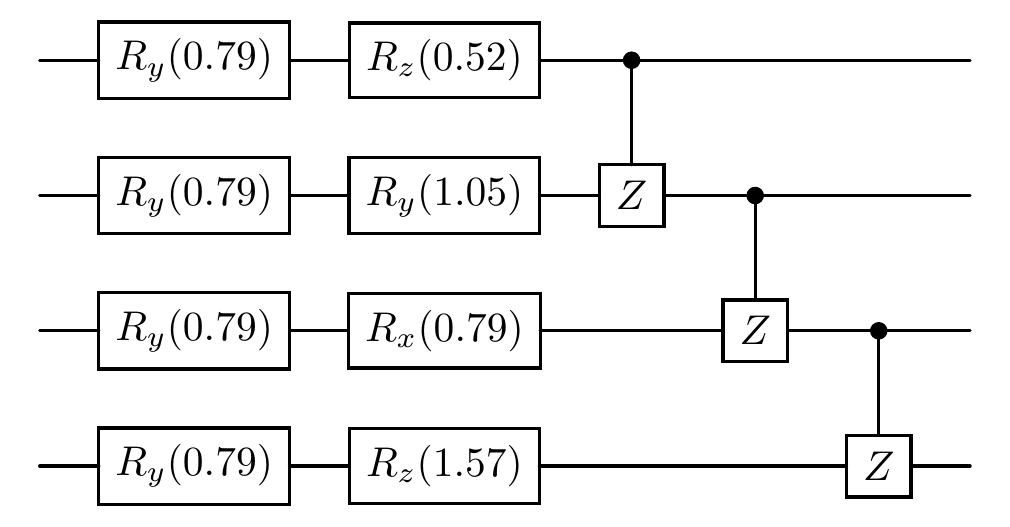

In [3]:
num_qubits = 4  # Set the number of qubits
target = ['z', 'y', 'x', 'z']  # Define the target array, representing the rotation type for each qubit
theta = [torch.pi / 6, torch.pi / 3, torch.pi / 4, torch.pi / 2]  # Define the rotation angles

# Call the rand_circuit function to create the quantum circuit
quantum_circuit = rand_circuit(target, num_qubits, theta)

print('The circuit is as follows: ')
# Output the quantum circuit
quantum_circuit.plot()

## 3. Loss function and optimization landscape <a id="loss"></a>

After determining the circuit structure, we also need to define a loss function to determine the optimization landscape. Following the same setup as McClean (2018) [1], we take the loss function from VQE:

$$
L(\theta) = \langle 0 | U^\dagger(\theta) H U(\theta) | 0 \rangle
\tag{1}
$$

The unitary matrix $U(\theta)$ is the quantum neural network with the random structure that we build from the last section. For the Hamiltonian $H$, we also take the simplest form:

$$
H = |00 \cdots 0 \rangle \langle 00 \cdots 0 |
\tag{2}
$$


In [4]:
def loss_fcn(circuit: Circuit) -> torch.Tensor:
    r"""The loss function defined in Equation 1
    
    Args:
        circuit: The input quantum circuit.
        
    Returns:
        The expectation value with respect to the Hamiltonian in Equation 2.
    
    """
    output_states = circuit().ket.squeeze(-1)
    return (output_states[:, 0] * torch.conj(output_states[:, 0])).real

After that, we can start sampling gradients with the two-qubit case. We generate 300 sets of random network structures and different random initial parameters $\{ \theta^{(i)}_{\ell,n} \}$ for $i = 1$ to 300. Each time, the partial derivative with respect to the **first parameter** $\theta_{1,1}$ is calculated according to the analytical gradient formula from VQE. Then we analyze the mean and variance of these 300 sampled partial gradients. The formula for the analytical gradient is:

$$
\frac{\partial L}{\partial \theta_j}  = \frac{1}{2} \left[ L\left(\theta_j + \frac{\pi}{2}\right) - L\left(\theta_j - \frac{\pi}{2}\right) \right]
\tag{3}
$$

For a detailed derivation, see [2].

In [5]:
# Hyper parameter settings
num_qubits = 2                # Set the number of qubits
samples = 300        # Set the number of sampled random network structures
THETA_SIZE = num_qubits      # Set the size of the parameter theta

# Initialize the register for the gradient value
list_grad = []


# Record running time
time_start = time.time()

# Randomly generate angles with in the range [0, 2pi) of dimension (samples, THETA_SIZE)
sample_theta = 2 * torch.pi * torch.rand([samples, THETA_SIZE])

# Prepare theta_plus and theta_minus
list_theta = sample_theta.unsqueeze(-1).repeat([1, 1, 2])
list_theta[:, 0, 0] += torch.pi / 2
list_theta[:, 0, 1] -= torch.pi / 2

In [6]:
# Start sampling
for i in range(samples):
    target_gate = np.random.choice(['x', 'y', 'z'], num_qubits)
    
    # Generate two quantum circuits with random gates
    theta = list_theta[i]
    cir = rand_circuit(target_gate, num_qubits, theta)
    
    # Compute loss difference, which is the gradient of the circuit
    loss_plus, loss_minus = loss_fcn(cir)
    list_grad.append((loss_plus - loss_minus) / 2)
    
# # Stack all elements in the grad list into a single tensor
grad_info = torch.stack(list_grad) 
time_span = time.time() - time_start

print(f"The program segment has run in {time_span} seconds")
print(f"{samples} gradient of the random sample network's first parameter have ")
print(f"    mean value: {torch.mean(grad_info).item()}")
print(f"    variance: {torch.var(grad_info).item()}")

The program segment has run in 1.201246976852417 seconds
300 gradient of the random sample network's first parameter have 
    mean value: -0.00010895199490029058
    variance: 0.03235830475011178


## 4. Visualization of the Optimization landscape <a id="visualization"></a>

Next, we use Matplotlib to visualize the optimization landscape. In the case of two qubits, we only have two parameters $\theta_1$ and $\theta_2$, and there are 9 possibilities for the random circuit structure in the second layer.

If you want to try to draw some optimization landscapes yourself, please refer to the following code:




In [7]:
time_start = time.time()

# Generate points on the x, y axis
theta_1_list = torch.linspace(0, 2 * torch.pi, 80)
theta_2_list = torch.linspace(0, 2 * torch.pi, 80)

# Generate 2D mesh
theta_1_axis, theta_2_axis = np.meshgrid(theta_1_list, theta_2_list)
list_param = torch.stack([theta_1_list.repeat(len(theta_2_list)).unsqueeze(1), theta_2_list.repeat_interleave(len(theta_1_list)).unsqueeze(1)], dim=0)

We visualize the cases where the second layer are Rx-Rx, Rx-Ry, Rx-Rz, Ry-Rx, Ry-Ry, Ry-Rz, Rz-Rx, Rz-Ry, Rz-Rz, respectively: 


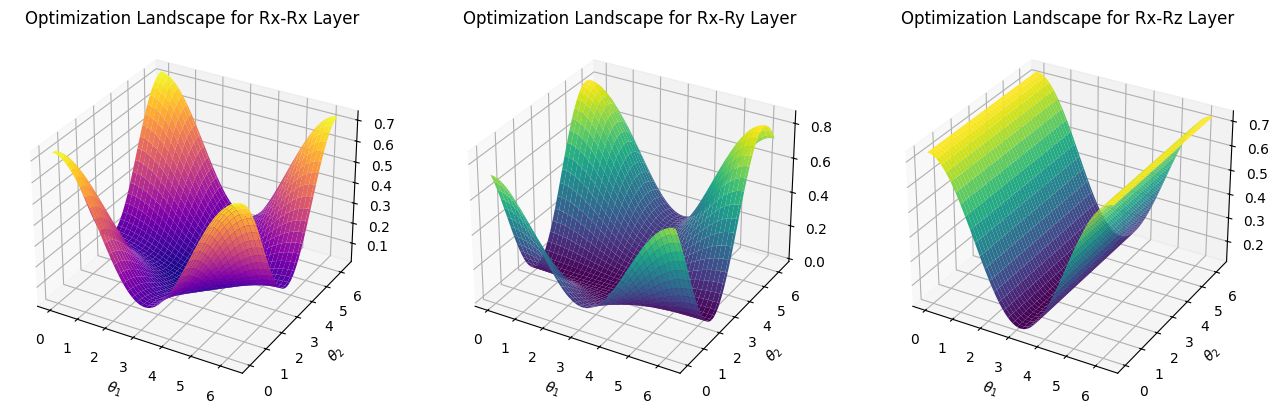

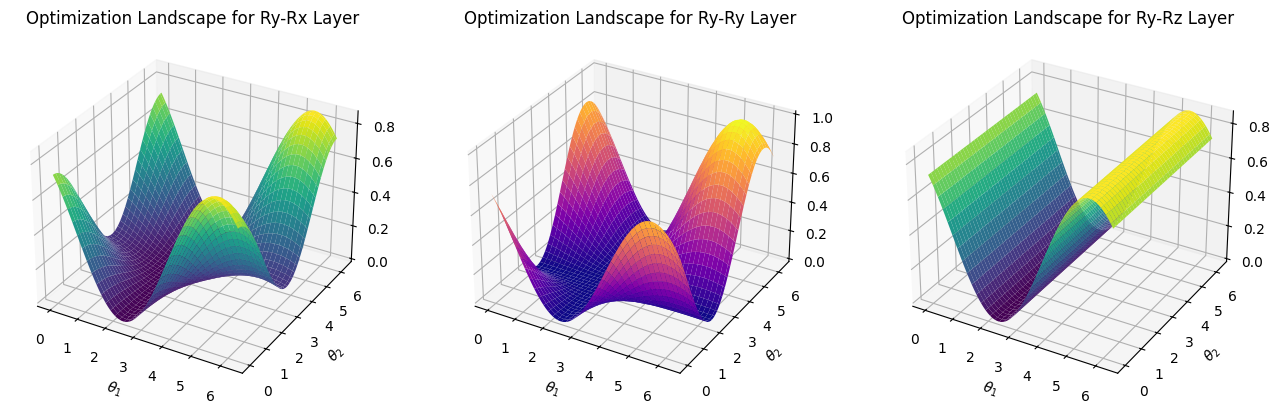

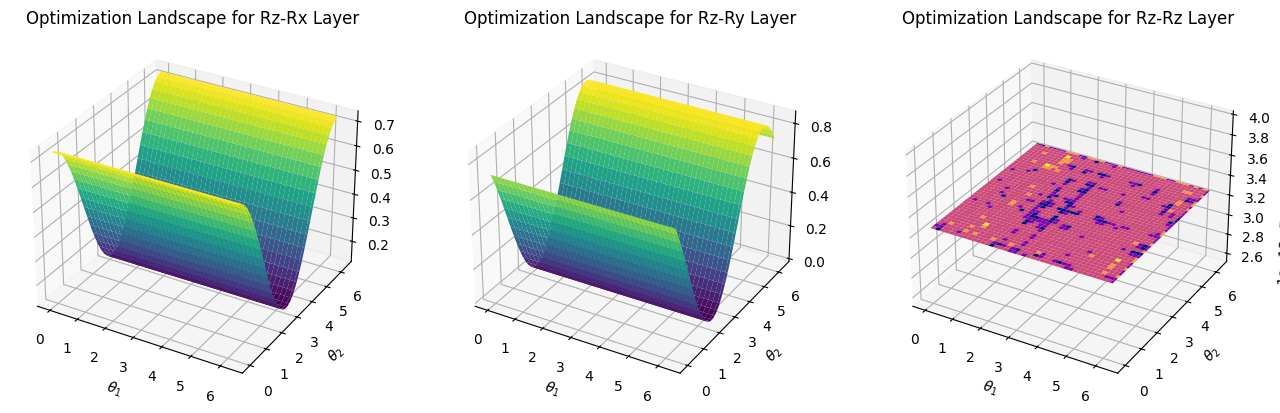

The main program segment has run in total 4.465364217758179 seconds


In [8]:
# Set the image ratio Vertical: Horizontal = 0.3
fig_1 = plt.figure(figsize=plt.figaspect(0.3))
fig_2 = plt.figure(figsize=plt.figaspect(0.3))
fig_3 = plt.figure(figsize=plt.figaspect(0.3))

# ============= The first figure =============
# We visualize the case where the second layer is kron(Rx, Rx)
ax = fig_1.add_subplot(1, 3, 1, projection='3d')

cir = Circuit(num_qubits)

# Apply a rotation around the y-axis with a parameter of π/4 to the first layer
cir.ry(param=torch.pi/4)

# Apply a rotation around the x-axis with a parameter defined by list_param to the second layer
cir.rx(param=list_param)

# Add a controlled-Z gate to the circuit
cir.cz()

# Compute the density matrix of the circuit and extract the (0, 0) element,
# reshape it according to the lengths of theta_2_list and theta_1_list,
# and detach it from the computation graph before converting it to a NumPy array
U_00_val = cir().density_matrix.real[:,0,0].reshape(len(theta_2_list), len(theta_1_list)).detach().numpy()

# Create a 3D surface plot of U_00_val with theta_1_axis and theta_2_axis as the axes,
# using the 'plasma' colormap
surf = ax.plot_surface(theta_1_axis, theta_2_axis, U_00_val, cmap='plasma')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Rx-Rx Layer")

# ============= The second figure =============
# We visualize the case where the second layer is kron(Rx, Ry)
ax = fig_1.add_subplot(1, 3, 2, projection='3d')

cir = Circuit(num_qubits)
cir.ry(param=torch.pi/4)
cir.rx(0, param=list_param[0])  
cir.ry(1, param=list_param[1])  
cir.cz()  
U_00_val = cir().density_matrix.real[:,0,0].reshape(len(theta_2_list), len(theta_1_list)).detach().numpy()
surf = ax.plot_surface(theta_1_axis, theta_2_axis, U_00_val, cmap='viridis')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Rx-Ry Layer")

# ============= The third figure =============
# We visualize the case where the second layer is kron(Rx, Rz)
ax = fig_1.add_subplot(1, 3, 3, projection='3d')

cir = Circuit(num_qubits)
cir.ry(param=torch.pi/4)
cir.rx(0, param=list_param[0])  
cir.rz(1, param=list_param[1])  
cir.cz()  
U_00_val = cir().density_matrix.real[:,0,0].reshape(len(theta_2_list), len(theta_1_list)).detach().numpy()
surf = ax.plot_surface(theta_1_axis, theta_2_axis, U_00_val, cmap='viridis')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Rx-Rz Layer")

# ============= The fourth figure =============
# We visualize the case where the second layer is kron(Ry, Rx)
ax = fig_2.add_subplot(1, 3, 1, projection='3d')

cir = Circuit(num_qubits)
cir.ry(param=torch.pi/4)
cir.ry(0, param=list_param[0])  
cir.rx(1, param=list_param[1])  
cir.cz()  
U_00_val = cir().density_matrix.real[:,0,0].reshape(len(theta_2_list), len(theta_1_list)).detach().numpy()
surf = ax.plot_surface(theta_1_axis, theta_2_axis, U_00_val, cmap='viridis')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Ry-Rx Layer")

# ============= The fifth figure =============
# We visualize the case where the second layer is kron(Ry, Ry)
ax = fig_2.add_subplot(1, 3, 2, projection='3d')

cir = Circuit(num_qubits)
cir.ry(param=torch.pi/4)
cir.ry(param=list_param)  
cir.cz()  
U_00_val = cir().density_matrix.real[:,0,0].reshape(len(theta_2_list), len(theta_1_list)).detach().numpy()
surf = ax.plot_surface(theta_1_axis, theta_2_axis, U_00_val, cmap='plasma')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Ry-Ry Layer")

# ============= The sixth figure =============
# We visualize the case where the second layer is kron(Ry, Rz)
ax = fig_2.add_subplot(1, 3, 3, projection='3d')

cir = Circuit(num_qubits)
cir.ry(param=torch.pi/4)
cir.ry(0, param=list_param[0])  
cir.rz(1, param=list_param[1])  
cir.cz()  
U_00_val = cir().density_matrix.real[:,0,0].reshape(len(theta_2_list), len(theta_1_list)).detach().numpy()
surf = ax.plot_surface(theta_1_axis, theta_2_axis, U_00_val, cmap='viridis')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Ry-Rz Layer")

# ============= The seventh figure =============
# We visualize the case where the second layer is kron(Rz, Rx)
ax = fig_3.add_subplot(1, 3, 1, projection='3d')

cir = Circuit(num_qubits)
cir.ry(param=torch.pi/4)
cir.rz(0, param=list_param[0])  
cir.rx(1, param=list_param[1])  
cir.cz()  
U_00_val = cir().density_matrix.real[:,0,0].reshape(len(theta_2_list), len(theta_1_list)).detach().numpy()
surf = ax.plot_surface(theta_1_axis, theta_2_axis, U_00_val, cmap='viridis')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Rz-Rx Layer")

# ============= The eighth figure =============
# We visualize the case where the second layer is kron(Rz, Ry)
ax = fig_3.add_subplot(1, 3, 2, projection='3d')

cir = Circuit(num_qubits)
cir.ry(param=torch.pi/4)
cir.rz(0, param=list_param[0])  
cir.ry(1, param=list_param[1])  
cir.cz()  
U_00_val = cir().density_matrix.real[:,0,0].reshape(len(theta_2_list), len(theta_1_list)).detach().numpy()
surf = ax.plot_surface(theta_1_axis, theta_2_axis, U_00_val, cmap='viridis')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Rz-Ry Layer")

# ============= The ninth figure =============
# We visualize the case where the second layer is kron(Rz, Rz)
ax = fig_3.add_subplot(1, 3, 3, projection='3d')

cir = Circuit(num_qubits)
cir.ry(param=torch.pi/4)
cir.rz(param=list_param) 
cir.cz()  
U_00_val = cir().density_matrix.real[:,0,0].reshape(len(theta_2_list), len(theta_1_list)).detach().numpy()
surf = ax.plot_surface(theta_1_axis, theta_2_axis, U_00_val, cmap='plasma')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Rz-Rz Layer")

#this is equivalent to below code
# U_00_val_list=[]
# for j in theta_2_list:
#     for  i theta_1_list:
#         cir = Circuit(num_qubits)
#         cir.ry(param=torch.pi/4)
#         cir.rz(0, param=i)  
#         cir.rz(1, param=j)  
#         cir.cz()
#         val=cir().density_matrix.real[0,0].detach().numpy()
#         U_00_val_list.append(val)
       
# U_00_val = np.array(U_00_val_list).reshape(len(theta_2_list), len(theta_1_list))
# surf = ax.plot_surface(theta_1_axis, theta_2_axis, U_00_val, cmap='plasma')
# ax.set_xlabel(r"$\theta_1$")
# ax.set_ylabel(r"$\theta_2$")
# ax.set_title("Optimization Landscape for Rz-Rz Layer")

print('We visualize the cases where the second layer are Rx-Rx, Rx-Ry, Rx-Rz, Ry-Rx, Ry-Ry, Ry-Rz, Rz-Rx, Rz-Ry, Rz-Rz, respectively: ')
plt.show()

time_span = time.time() - time_start        
print(f"The main program segment has run in total {time_span} seconds")

The plain structure shown in the $R_z-R_z$ layer from the last figure is something we should avoid. In this case, it's nearly impossible to converge to the theoretical minimum.

---

## References

[1] McClean, Jarrod R., et al. "Barren plateaus in quantum neural network training landscapes." Nature communications 9.1 (2018): 4812.

[2] Mitarai, Kosuke, et al. "Quantum circuit learning." Physical Review A 98.3 (2018): 032309.

*Table: A reference of notation conventions in this tutorial.*

| Symbol        | Variant          | Description                               |
|:---------------:|:------------------:|-------------------------------------------|
| $R_{x/y/z}(\theta)$     |      |rotation gates about the $X$/$Y$/$Z$-axis  |
| $ U(\theta)$     |      |the unitary matrix  |
| $L(\theta) = \langle 0 \| U^\dagger(\theta) H U(\theta) \| 0 \rangle$     |      |the loss function from VQE  |
| $\frac{\partial L}{\partial \theta_j}$     |      |the partial derivative of the loss function with respect to  $\theta_j $ |
| $H$     |      |Hamiltonian  |

In [9]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.0
torch: 2.7.0+cpu
numpy: 1.26.0
scipy: 1.14.1
matplotlib: 3.10.0
---------SYSTEM---------
Python version: 3.10.16
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
